<h2> Interpret ML

In [1]:
#in the following code, a Gaussian Naive Bayes Classifier will be build to predict whether a person makes over 50K a year

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), Python data analysis library
import matplotlib.pyplot as plt # for data visualization purposes
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from interpret.data import ClassHistogram
from interpret.data import Marginal
from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import RegressionPerf

<h2> Loading the dataset

In [2]:
#import dataset
path = 'C:/Users/evafi/bayes_xml/dataset/adult_income_dataset.csv'
data = pd.read_csv(path, sep=",")
#top 5 of each column
print(data.head())

   age  workclass  fnlwgt     education  educational-num      marital-status   
0   25    Private  226802          11th                7       Never-married  \
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss   
0  Machine-op-inspct    Own-child  Black    Male             0             0  \
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country incom

In [3]:
#rename column names
col_names = ["Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]
data.columns = col_names
data.columns

Index(['Age', 'WorkClass', 'fnlwgt', 'Education', 'EducationNum',
       'MaritalStatus', 'Occupation', 'Relationship', 'Race', 'Gender',
       'CapitalGain', 'CapitalLoss', 'HoursPerWeek', 'NativeCountry',
       'Income'],
      dtype='object')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Age            48842 non-null  int64 
 1   WorkClass      48842 non-null  object
 2   fnlwgt         48842 non-null  int64 
 3   Education      48842 non-null  object
 4   EducationNum   48842 non-null  int64 
 5   MaritalStatus  48842 non-null  object
 6   Occupation     48842 non-null  object
 7   Relationship   48842 non-null  object
 8   Race           48842 non-null  object
 9   Gender         48842 non-null  object
 10  CapitalGain    48842 non-null  int64 
 11  CapitalLoss    48842 non-null  int64 
 12  HoursPerWeek   48842 non-null  int64 
 13  NativeCountry  48842 non-null  object
 14  Income         48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
col_n = data.columns
num_data = data.shape[0]
for c in col_n:
    num_non = data[c].isin(["?"]).sum()
    if num_non > 0:
        print(c)
        print(num_non)
        print("{0:.2f}%".format(float(num_non) / num_data * 100))

WorkClass
2799
5.73%
Occupation
2809
5.75%
NativeCountry
857
1.75%


In [6]:
# replace '?' values in workclass variable with `NaN`
data['WorkClass'].replace('?', np.NaN, inplace=True)
# replace '?' values in occupation variable with `NaN`
data['Occupation'].replace('?', np.NaN, inplace=True)
# replace '?' values in native_country variable with `NaN`
data['NativeCountry'].replace('?', np.NaN, inplace=True)

<h2>Building the Model

In [7]:
X = data.iloc[:, :-1]
#y = data.iloc[:, -1]
income = data['Income']
y = income.map({'<=50K':0, '>50K':1})

In [8]:
y.head()

0    0
1    0
2    1
3    1
4    0
Name: Income, dtype: int64

In [9]:
seed = 42
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [10]:
X_train.dtypes

Age               int64
WorkClass        object
fnlwgt            int64
Education        object
EducationNum      int64
MaritalStatus    object
Occupation       object
Relationship     object
Race             object
Gender           object
CapitalGain       int64
CapitalLoss       int64
HoursPerWeek      int64
NativeCountry    object
dtype: object

In [11]:
X_train.shape, X_test.shape

((39073, 14), (9769, 14))

In [13]:
# display categorical variables
categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']
categorical

['WorkClass',
 'Education',
 'MaritalStatus',
 'Occupation',
 'Relationship',
 'Race',
 'Gender',
 'NativeCountry']

In [14]:
# print categorical variables with missing data
for col in categorical:
    if X_train[col].isnull().mean()>0:
        print(col, (X_train[col].isnull().mean()))

X_train[categorical].isnull().sum()

WorkClass 0.05794282496864843
Occupation 0.05817316305377115
NativeCountry 0.01717298390192716


WorkClass        2264
Education           0
MaritalStatus       0
Occupation       2273
Relationship        0
Race                0
Gender              0
NativeCountry     671
dtype: int64

In [15]:
# impute missing categorical variables with most frequent value
for df2 in [X_train, X_test]:
    df2['WorkClass'].fillna(X_train['WorkClass'].mode()[0], inplace=True)
    df2['Occupation'].fillna(X_train['Occupation'].mode()[0], inplace=True)
    df2['NativeCountry'].fillna(X_train['NativeCountry'].mode()[0], inplace=True) 

<h2> Explore the data

In [16]:
# shows the distribution of classes
hist = ClassHistogram().explain_data(X_train, y_train, name="Train Data")
show(hist)

<!-- http://127.0.0.1:7001/2603269836608/ -->

In [30]:
#marginal plot for provided data
#how is the training data distributed over a specific range of value
#Pearson correlation coefficient to interpret the linear relationship of these features with respect to the target
marginal = Marginal().explain_data(X_train, y_train, name='Train Data')
show(marginal)

<!-- http://127.0.0.1:7001/2603401836384/ -->

<h2> Training the Explainable Boosting Machine (EBM)

In [18]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier()

In [19]:
auc = roc_auc_score(y_test, ebm.predict_proba(X_test)[:, 1])
print("AUC: {:.3f}".format(auc))

AUC: 0.931


<h4> Global Explanations - explaining the entire model behavior

In [20]:
#The term importances are the mean absolute contribution (score) each term (feature or interaction) makes to predictions averaged 
#across the training dataset. Contributions are weighted by the number of samples in each bin, and by the sample weights (if any). 
#The 15 most important terms are shown.
ebm_global = ebm.explain_global()
show(ebm_global)
#InterpretML shows, what values of each feature have the strongest influence to 0 or 1

<!-- http://127.0.0.1:7001/2603345203552/ -->

<h4> Local Explanations: explaining individual predictions

In [21]:
#A local explanation shows the breakdown of how much each term contributed to the prediction for a single sample. 
#The intercept reflects the average case. In regression, the intercept is the average y-value of the train set. 
#In classification, the intercept is the log of the base rate. 
#The 15 most important terms are shown
ebm_local = ebm.explain_local(X_test[:5], y_test[:5], name = 'EBM')
show(ebm_local)
#shows the true value 0 or 1 and the EBM predicted value and which feature was the main driver in the explanation

<!-- http://127.0.0.1:7001/2603332386192/ -->

<function matplotlib.pyplot.show(close=None, block=None)>

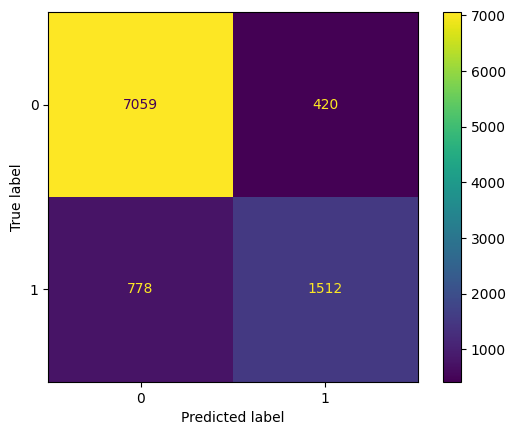

In [22]:
predictions = ebm.predict(X_test)
cm = confusion_matrix(y_test.to_numpy(), predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show

In [27]:
auc = accuracy_score(y_test, ebm.predict(X_test))
print("Accuracy: {:.3f}".format(auc))
f1 = f1_score(y_test, ebm.predict(X_test))
print("F1score: {:.3f}".format(f1))
roc = roc_auc_score(y_test, ebm.predict_proba(X_test)[:, 1])
print("AUC: {:.3f}".format(roc))

confusion_matrix(y_test, ebm.predict(X_test))

Accuracy: 0.877
F1score: 0.716
AUC: 0.931


array([[7059,  420],
       [ 778, 1512]], dtype=int64)

<h2> Classification report

In [25]:
cr = classification_report(y_test.to_numpy(), predictions)
print(cr)
#f1 score is close to 1, so the model is good

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7479
           1       0.78      0.66      0.72      2290

    accuracy                           0.88      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.88      0.87      9769



In [26]:
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7001/2603345735936/ -->

In [29]:
show([hist, marginal, ebm_global, ebm_local])

<!-- http://127.0.0.1:7001/2603412609088/ -->
 Open in new window